# Planejamento da Solução

- Qual é o Entregável?

- Reportar ao Head de Design qual é a melhor forma de pagamento: Preenchimento Manual ou Automático do formulário de dados do cartão de crétito

- Quais dados nós temos

- uid: Id do Cliente 
- Country: País do Cliente
- Gender: Gênero do Cliente
- spent: Valor monetário que o Cliente gastou
- purchases: Quantidade de Compras 
- Date:

- Group: 
    - A: Preenchimento Automático
    - B: Preenchimento Manual

- Device:
    - I: Compra feita através do site 
    - A: Compra feita através do App

# Imports

In [49]:
import pandas as pd
import seaborn as sns
import math
import statsmodels.stats.weightstats as ws
import numpy as np
from statsmodels.stats import api as sms

from scipy.stats import shapiro,mannwhitneyu, ttest_ind
from pingouin import compute_effsize



import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Helper Functions

In [52]:
def analise_normalidade(base_control, base_treatment, alpha):
    stats1, pvalue1 = shapiro(base_control)
    stats2, pvalue2 = shapiro(base_treatment)

    if (alpha < pvalue1) and (alpha < pvalue2):
        return True
        
    else:
        return False

def analise_variancia(base_control, base_treatment):

    var_control = np.var(base_control)
    var_treatment = np.var(base_treatment)

    if var_control > var_treatment:
        maior_var = var_control
        menor_var = var_treatment
    else:
        maior_var = var_treatment
        menor_var = var_control

    if (maior_var/menor_var) < 4:
        return True
    else:
        return False

# Data Load

In [2]:
df = pd.read_csv('../data/ab_testing.csv')

# 1.0 Descrição dos Dados

In [3]:
df1 = df.copy()

## 1.1 Dimensão dos Dados

In [4]:
df1.shape

(45883, 8)

## 1.2 Check Na

In [5]:
df1.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

In [6]:
df1 = df1.dropna()

## 1.3 Data Types

In [7]:
df1.dtypes

uid           int64
country      object
gender       object
spent         int64
purchases     int64
date         object
group        object
device       object
dtype: object

## 1.4 Change Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])

# 2.0 EDA

In [9]:
df2 = df1.copy()

In [10]:
df2[['uid','group']].groupby('group').count().reset_index()

,group,uid
0,GRP A,23009
1,GRP B,22874


In [11]:
df2[['uid','device']].groupby('device').count().reset_index()

,device,uid
0,A,22982
1,I,22901


In [12]:
df2[['uid','country']].groupby('country').count().reset_index().sort_values('uid', ascending=False)

,country,uid
9,USA,13998
1,BRA,9009
7,MEX,5528
3,DEU,3696
8,TUR,3537
5,FRA,2842
6,GBR,2809
4,ESP,1934
2,CAN,1513
0,AUS,1017


## 2.1 Gastos por País

<Axes: xlabel='country', ylabel='spent'>

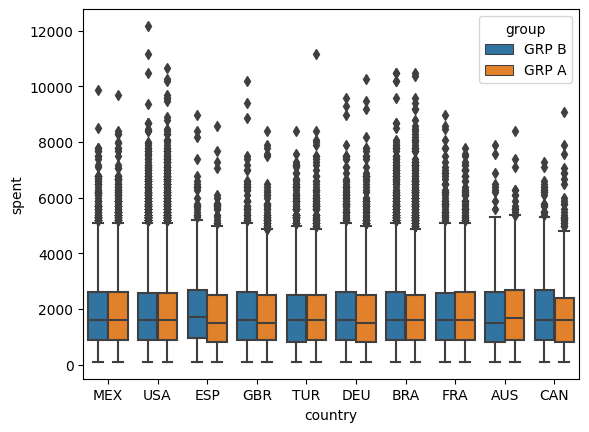

In [13]:
# Gasto por País
sns.boxplot(x=df2['country'], y=df2['spent'], hue=df2['group'])


## 2.2 Gastos por Gênero

<Axes: xlabel='gender', ylabel='spent'>

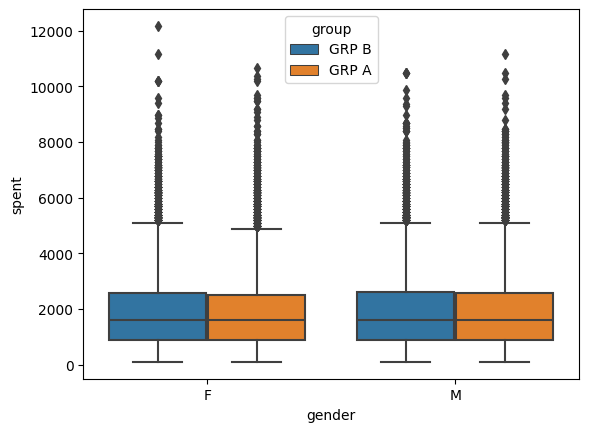

In [14]:
# Gasto por Gênero
sns.boxplot(x=df2['gender'], y=df2['spent'], hue=df2['group'])


## 2.3 Gastos por Device

<Axes: xlabel='device', ylabel='spent'>

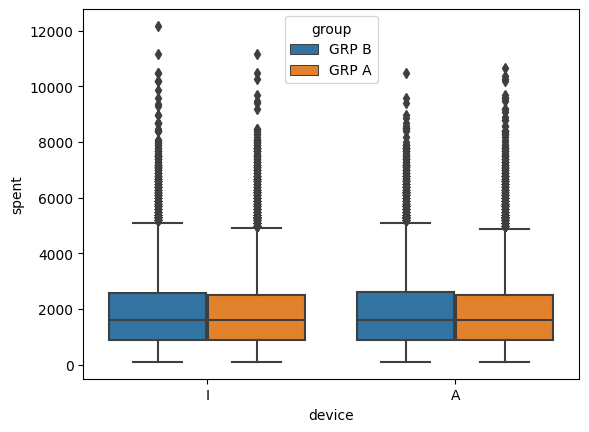

In [15]:
# Gasto por Device
sns.boxplot(x=df2['device'], y=df2['spent'], hue=df2['group'])


## 2.4 Gastos por Dia

<Axes: xlabel='date', ylabel='spent'>

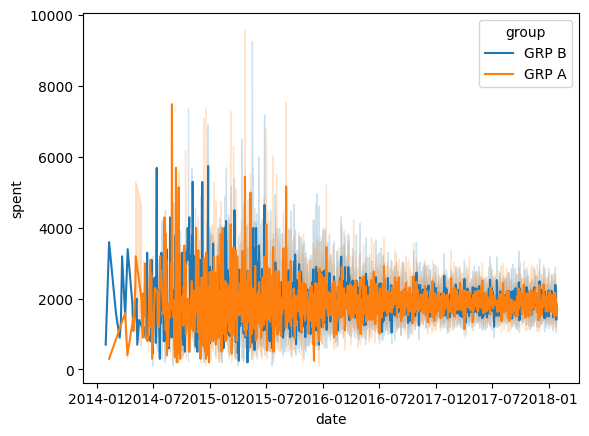

In [16]:
# Gastos por dia
sns.lineplot(x='date', y='spent',  data=df2, hue=df2['group'])

## 2.5 Gastos por Dia por Grupos

<Axes: xlabel='date', ylabel='spent'>

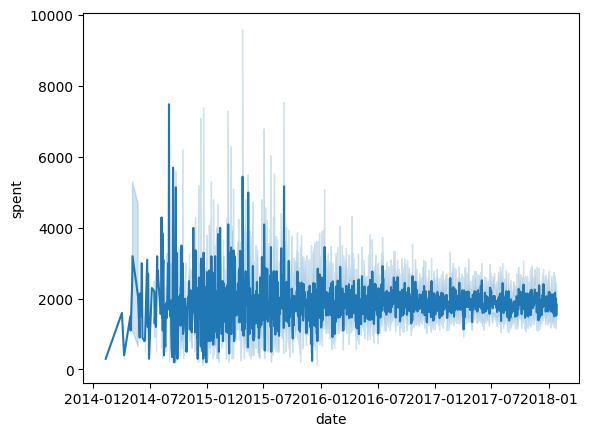

In [17]:
# Gastos por dia da página nova
sns.lineplot(x='date', y='spent', data=df2[df2['group'] == 'GRP A'])

<Axes: xlabel='date', ylabel='spent'>

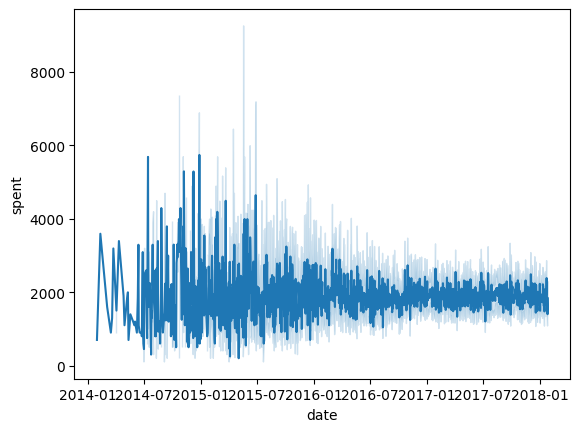

In [18]:
# Gastos por dia da página atual
sns.lineplot(x='date', y='spent', data=df2[df2['group'] == 'GRP B'])

## 2.6 Gastos por Grupos

<Axes: xlabel='group', ylabel='spent'>

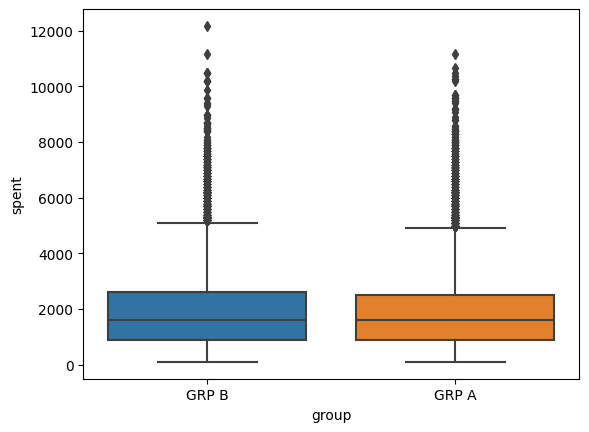

In [19]:
sns.boxplot(x=df2['group'], y=df2['spent'])

# 3.0 Design do Experimento

In [20]:
df3 = df2.copy()

## 3.1 Conferir Flags

In [21]:
df3[['uid','group']].groupby('uid').count().query('group > 1')

,group
uid,


## 3.2 Determinando Tamanho da Amostra

In [25]:
#atual_metric = media do faturamento atual
#new_metric =  O valor esperado com lift no faturamento com a nova página
results = pd.DataFrame()
paises = df3['country'].unique()
valores_lift = [0.05, 0.1, 0.11, 0.12, 0.15, 0.20]
nivel_confianca = [0.9, 0.95, 0.99]
power_stats = [0.6,0.7, 0.8, 0.9]
dict_results = {
    'Pais': [],
    'lift': [],
    'nivel_confianca': [],
    'nivel_significancia': [],
    'power_stats': [],
    'effect_size': [],
    'sample_n': [],
    'qtd_dados_disponiveis': [],
    'amostra_suficiente': []
}
for pais in paises:
    base_pais = df3[(df3['country'] == pais)]
    base_new_page = base_pais['spent'][(base_pais['group'] == 'GRP A')]
    base_current_page = base_pais['spent'][(base_pais['group'] == 'GRP B')]

    for lift in valores_lift:
        atual_metric = base_pais['spent'].mean()
        new_metric = base_pais['spent'].mean() + ( base_pais['spent'].mean() * lift)
        std_metric = np.std(base_pais['spent'])

        effect_size = (new_metric - atual_metric) / std_metric

        for nv_conf in nivel_confianca:
            for pw_est in power_stats:
                sample_n = math.ceil(sms.tt_ind_solve_power(
                        effect_size,
                        power=pw_est,
                        alpha= (100-(nv_conf*100)) /100

                    ))
                
                if (sample_n * 2) < base_pais.shape[0]:
                    possui_dados = 'Sim'
                else:
                    possui_dados = 'Não'

                dict_results = {
                    'Pais': pais,
                    'lift': lift,
                    'nivel_confianca': nv_conf,
                    'nivel_significancia': (100-(nv_conf*100)) /100,
                    'power_stats': pw_est,
                    'effect_size': effect_size,
                    'sample_n': sample_n,
                    'qtd_dados_disponiveis': base_new_page.shape[0] + base_current_page.shape[0],
                    'amostra_suficiente': possui_dados
                }

                results = pd.concat([results, pd.DataFrame([dict_results])], ignore_index=True)
             

        

In [35]:
results[results['amostra_suficiente'] == 'Sim']

,Pais,lift,nivel_confianca,nivel_significancia,power_stats,effect_size,sample_n,qtd_dados_disponiveis,amostra_suficiente
0,MEX,0.05,0.90,0.10,0.6,0.06984,1478,5528,Sim
1,MEX,0.05,0.90,0.10,0.7,0.06984,1930,5528,Sim
2,MEX,0.05,0.90,0.10,0.8,0.06984,2536,5528,Sim
4,MEX,0.05,0.95,0.05,0.6,0.06984,2010,5528,Sim
5,MEX,0.05,0.95,0.05,0.7,0.06984,2532,5528,Sim
...,...,...,...,...,...,...,...,...,...
715,CAN,0.20,0.95,0.05,0.9,0.27832,273,1513,Sim
716,CAN,0.20,0.99,0.01,0.6,0.27832,209,1513,Sim
717,CAN,0.20,0.99,0.01,0.7,0.27832,250,1513,Sim
718,CAN,0.20,0.99,0.01,0.8,0.27832,304,1513,Sim


- Podemos observar que com os dados de apenas dois Países (ESP e DEU) e com alguns parametros específicos conseguiremos prosseguir com o teste.

In [28]:
results[results['amostra_suficiente'] == 'Sim']

,Pais,lift,nivel_confianca,nivel_significancia,power_stats,effect_size,sample_n,qtd_dados_disponiveis,amostra_suficiente
0,MEX,0.05,0.90,0.10,0.6,0.06984,1478,5528,Sim
1,MEX,0.05,0.90,0.10,0.7,0.06984,1930,5528,Sim
2,MEX,0.05,0.90,0.10,0.8,0.06984,2536,5528,Sim
4,MEX,0.05,0.95,0.05,0.6,0.06984,2010,5528,Sim
5,MEX,0.05,0.95,0.05,0.7,0.06984,2532,5528,Sim
...,...,...,...,...,...,...,...,...,...
715,CAN,0.20,0.95,0.05,0.9,0.27832,273,1513,Sim
716,CAN,0.20,0.99,0.01,0.6,0.27832,209,1513,Sim
717,CAN,0.20,0.99,0.01,0.7,0.27832,250,1513,Sim
718,CAN,0.20,0.99,0.01,0.8,0.27832,304,1513,Sim


# Amostragem Aleatória dos Grupos de Tratamento e Controle

In [36]:
df4 = df3.copy()
possiveis_analises = results[results['amostra_suficiente'] == 'Sim']

# ESP

In [42]:
# params_esp = {
#     'pais': 'ESP',
#     'nivel_confianca': 0.9,
#     'nivel_significancia': 0.1,
#     'power_stats': 0.8,
#     'effect_size': -0.123153,
#     'sample_n': 816,
#     'qtd_dados_disponiveis': 1934,
#     'amostra_suficiente': 'Sim'
# }

possiveis_espanha = possiveis_analises.loc[possiveis_analises['Pais'] ==  'ESP']

In [53]:
for index, row in possiveis_espanha.iterrows():
    df_control_esp = df4.loc[ (df4['country'] == 'ESP') & (df4['group'] == 'GRP B')].sample(n = row['sample_n'], random_state=42)
    df_treatment_esp = df4.loc[(df4['country'] == 'ESP') & (df4['group'] == 'GRP A')].sample(n = row['sample_n'], random_state=42)
    df_ab_esp = pd.concat([df_control_esp,df_treatment_esp], axis=1)

    base_control = df_control_esp['spent']
    base_treatment = df_treatment_esp['spent']

    conversao_control = base_control.mean()
    conversao_treatment = df_treatment_esp['spent'].mean()

    if analise_normalidade(base_control, base_treatment, row['nivel_significancia']) and analise_variancia(base_control, base_treatment):
            #Aplicamos T-TEST
            stats, pvalue = ttest_ind(base_control, base_treatment)

            if row['nivel_significancia'] < pvalue:
                print('As médias das duas páginas são iguais')
            else:
                print('As médias das duas páginas não são iguais')    
    else:
        stats, pvalue = mannwhitneyu(base_control, base_treatment)

        if row['nivel_significancia'] < pvalue:
            print('As médias das duas páginas são iguais')
        else:
            print('As médias das duas páginas não são iguais')

As médias das duas páginas não são iguais
As médias das duas páginas não são iguais
As médias das duas páginas não são iguais
As médias das duas páginas não são iguais
As médias das duas páginas não são iguais
As médias das duas páginas não são iguais
As médias das duas páginas não são iguais
As médias das duas páginas são iguais
As médias das duas páginas não são iguais
As médias das duas páginas são iguais
As médias das duas páginas não são iguais
As médias das duas páginas não são iguais
As médias das duas páginas não são iguais
As médias das duas páginas são iguais
As médias das duas páginas não são iguais
As médias das duas páginas não são iguais
As médias das duas páginas não são iguais
As médias das duas páginas são iguais
As médias das duas páginas são iguais
As médias das duas páginas não são iguais
As médias das duas páginas são iguais
As médias das duas páginas não são iguais
As médias das duas páginas não são iguais
As médias das duas páginas não são iguais
As médias das du

In [97]:
df_control_esp = df4.loc[ (df4['country'] == 'ESP') & (df4['group'] == 'GRP B')].sample(n = params_esp['sample_n'], random_state=42)
df_treatment_esp = df4.loc[(df4['country'] == 'ESP') & (df4['group'] == 'GRP A')].sample(n = params_esp['sample_n'], random_state=42)
df_ab_esp = pd.concat([df_control_esp,df_treatment_esp], axis=1)

## Conversão dos Dois Grupos

In [104]:
base_control = df_control_esp['spent']
base_treatment = df_treatment_esp['spent']

conversao_control = base_control.mean()
conversao_treatment = df_treatment_esp['spent'].mean()

print('Conversão do Grupo Controle: {}'.format(conversao_control))
print('Conversão do Grupo Tratamento: {}'.format(conversao_treatment))

Conversão do Grupo Controle: 1944.8786764705883
Conversão do Grupo Tratamento: 1811.5526960784314


- Quais seriam nossas Hipóteses?

    - H0: Não há diferença significativa entre as duas páginas
    - H1: Há diferença significativa entre as duas páginas


- Precisamos avaliar as Condições Paramétricas

    - Independência entre as amostras
    - Dados Normalmente Distribuídos
    - Variâncias iguais

## Analise de Normalidade

In [123]:
stats1, pvalue1 = shapiro(base_control)
stats2, pvalue2 = shapiro(base_treatment)

print('P-Value Control: {}'.format(pvalue1))
print('P-Value Treatment: {}'.format(pvalue2))

alpha = 0.1

if alpha < pvalue1:
    print('Os dados de Controle são normalmente distribuídos')
else:
    print('Os dados de Controle não são normalmente distribuídos')

if alpha < pvalue2:
    print('Os dados de Tratamento são normalmente distribuídos')
else:
    print('Os dados de Tratamento não são normalmente distribuídos')

P-Value Control: 6.052514873277099e-21
P-Value Treatment: 3.1974737260174393e-21
Os dados de Controle não são normalmente distribuídos
Os dados de Tratamento não são normalmente distribuídos


## Análise de Variância

In [111]:
print('Var Controle: {}'.format(np.var(base_control)))
print('Var Tratamento: {}'.format(np.var(base_treatment)))

if np.var(base_control)/np.var(base_treatment) < 4:
    print('Variâncias iguais')
else:
    print('Variâncias Diferentes')

Var Controle: 1757590.952192366
Var Tratamento: 1662267.2398701822
Variâncias iguais


## Teste Mann-Witney U

In [124]:
stats, pvalue = mannwhitneyu(base_control, base_treatment)
print(pvalue)

alpha = 0.1

if alpha < pvalue:
    print('As médias das páginas são iguais')
else:
    print('As médias das páginas não são iguais')

0.02467201927723883
As médias das páginas não são iguais


- É possível inferir que as médias das duas páginas na ESPANHA não são iguais.

- Portanto, A média de faturamento da Página Antiga é melhor do que o Faturamento da Página Nova no pa´s da Espanha.

# DEU

In [140]:
deu_base = possiveis_analises.loc[possiveis_analises['Pais'] == 'DEU']
params_deu = {
    'pais': 'DEU',
    'nivel_confianca': deu_base['nivel_confianca'].values[0],
    'nivel_significancia': deu_base['nivel_significancia'].values[0],
    'power_stats': deu_base['power_stats'].values[0],
    'effect_size': deu_base['effect_size'].values[0],
    'sample_n': deu_base['sample_n'].values[0],
    'qtd_dados_disponiveis': deu_base['qtd_dados_disponiveis'].values[0],
    'amostra_suficiente': deu_base['amostra_suficiente'].values[0]
}

In [142]:
df_control_deu = df4.loc[ (df4['country'] == 'DEU') & (df4['group'] == 'GRP B')].sample(n = params_deu['sample_n'], random_state=42)
df_treatment_deu = df4.loc[(df4['country'] == 'DEU') & (df4['group'] == 'GRP A')].sample(n = params_deu['sample_n'], random_state=42)
df_ab_deu = pd.concat([df_control_deu,df_treatment_deu], axis=1)

## Conversão dos Dois Grupos

In [146]:
base_control = df_control_deu['spent']
base_treatment = df_treatment_deu['spent']

conversao_control = base_control.mean()
conversao_treatment = base_treatment.mean()

print('Conversão do Grupo Controle: {}'.format(conversao_control))
print('Conversão do Grupo Tratamento: {}'.format(conversao_treatment))

Conversão do Grupo Controle: 1917.6790671848973
Conversão do Grupo Tratamento: 1826.363686840644
